<ipython-input-53-b513ecd011ff>:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8,8));


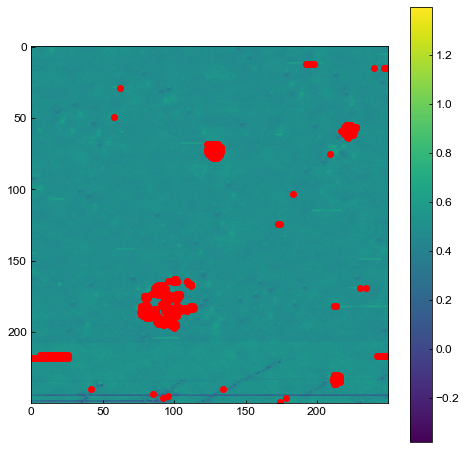

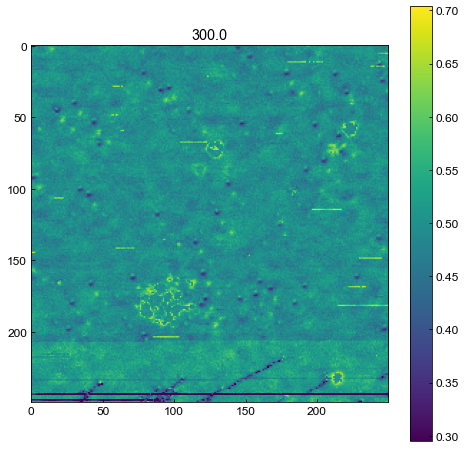

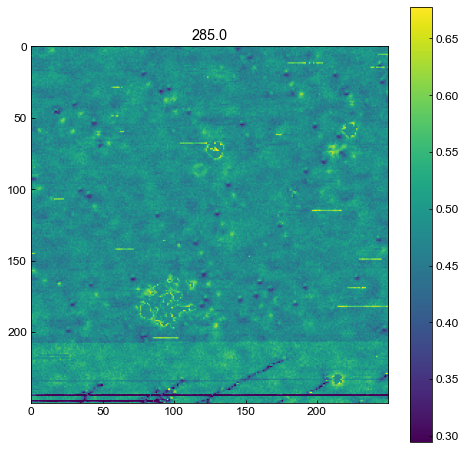

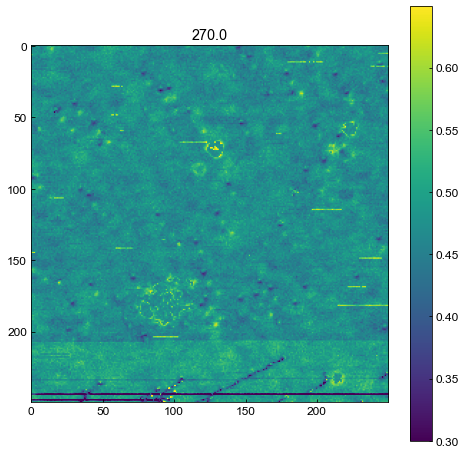

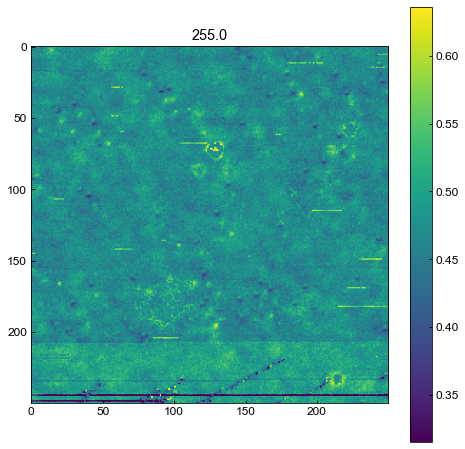

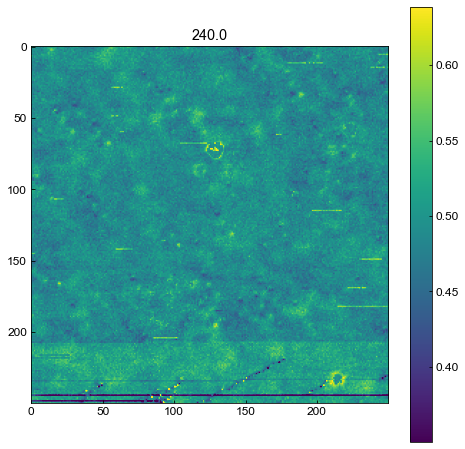

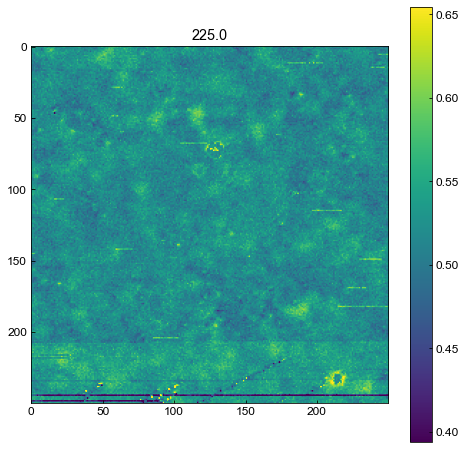

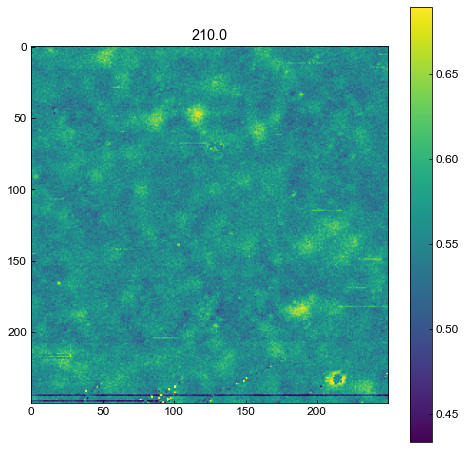

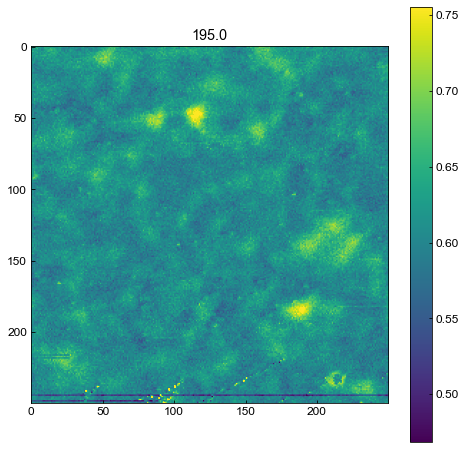

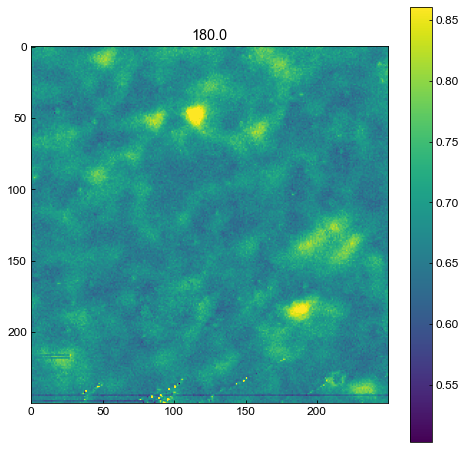

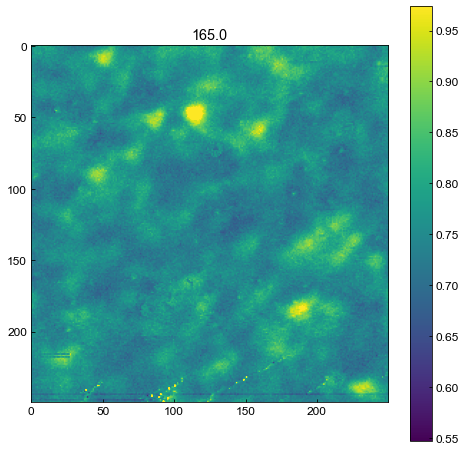

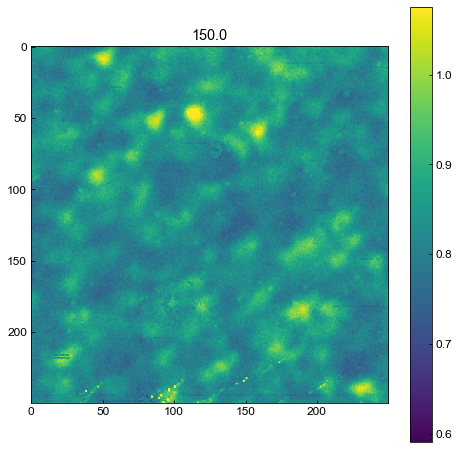

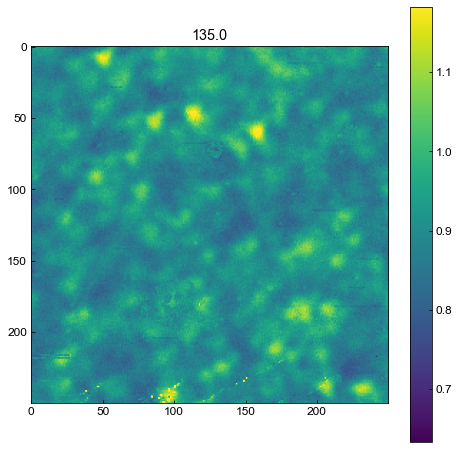

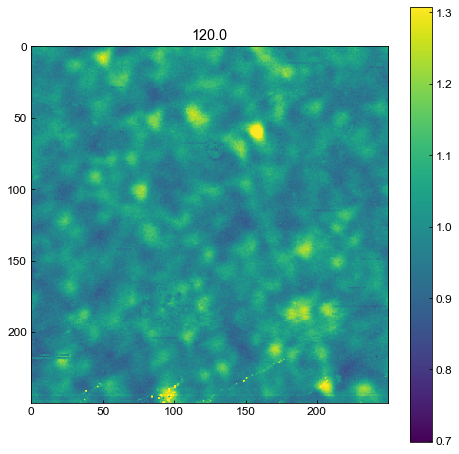

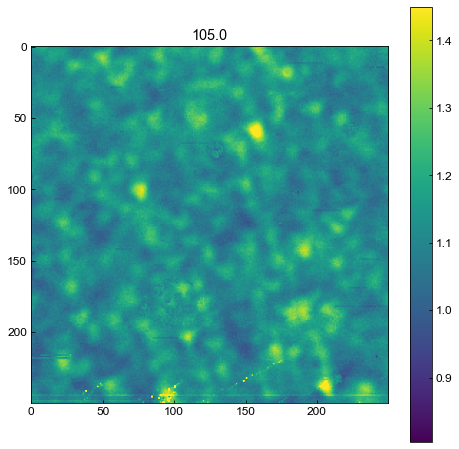

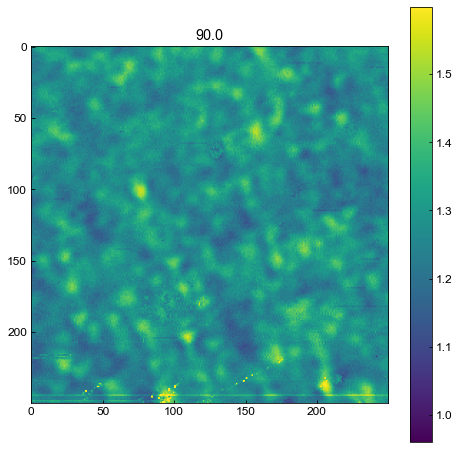

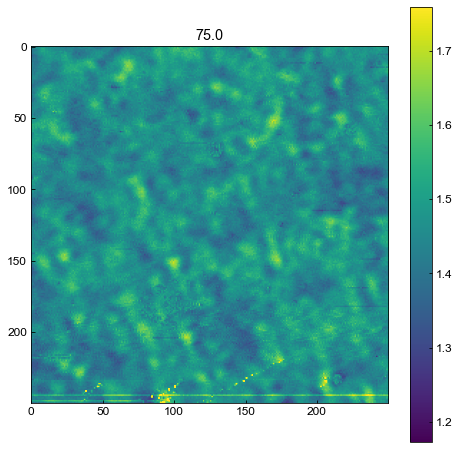

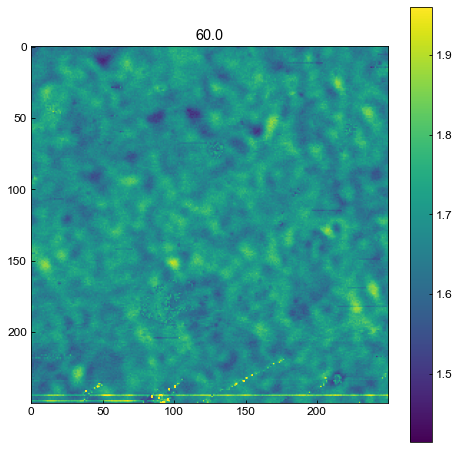

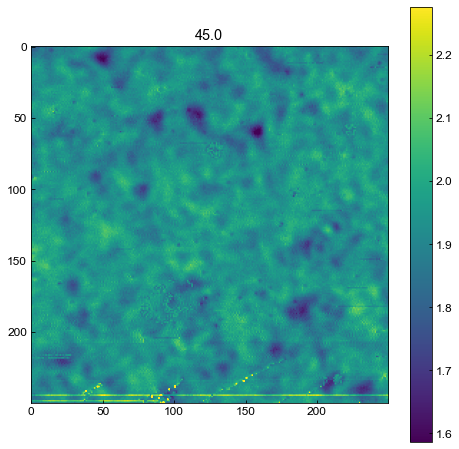

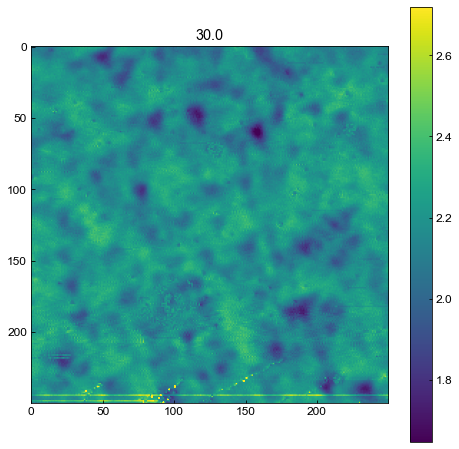

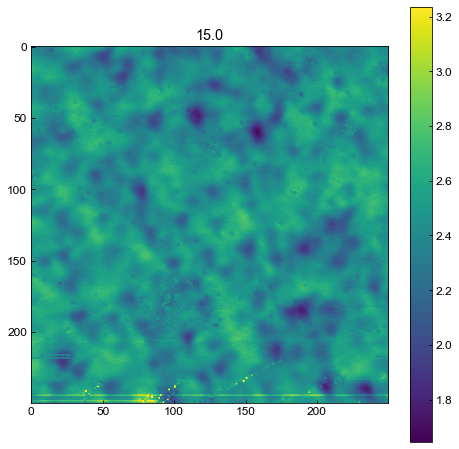

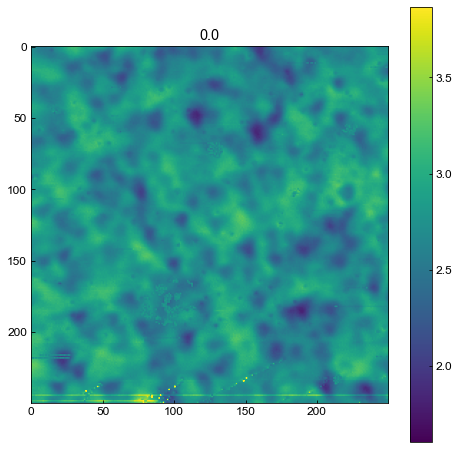

In [53]:
##########
cutoff = 200;
length=100;
angle=55;
cal=0.00628; # k-space pixel size: 2pi/framesize
##########


import nanonispy as nap; import matplotlib.pyplot as plt; import numpy as np; 
import matplotlib; import scipy.ndimage as scnd; import scipy as scipy; import math; import random;
matplotlib.rcParams['savefig.transparent'] = 'True';
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['lines.linewidth'] = 2.0
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['font.family'] = 'Arial'
filename="C:\\Users\\onesm\\Documents\\Madhavan Lab\\EuCd2As2\\Run#308 EuCd2As2 sample2\\Grid Spectroscopy003.3ds"
#filename="C:\\Users\\solid\\Desktop\\Seokjin_Data\\STM2 data\\Run#308 EuCd2As2 sample2\\Grid Spectroscopy004.3ds";
masklist=[];
slices=[];

##Gaussian filter for ffts
def sub_gaussian(fft, sx,sy):
    gauss=np.zeros((fft.shape))
    onevals=np.ones((fft.shape))
    x1=fft.shape[0]//2;y1=fft.shape[1]//2;
    amp=fft[x1,y1]
    for i in range(fft.shape[0]):
        for j in range(fft.shape[1]):
            gauss[i,j] = np.exp(-((i-x1)**2/(2*sx**2)+ (j-y1)**2/(2*sy**2)))
    new_fft = fft*(onevals-gauss)
    return new_fft  

##Takes the average of all the points not covered by a mask
def avgNonMasked(array, masklist):
    sumforavg=0; #initialize
    for a in range(array.shape[0]):
        for b in range(array.shape[1]):
            if (a,b) not in masklist:
                sumforavg=sumforavg+array[a,b] #adds up all non-masked points
    avgOfNonMaskedPts=sumforavg/(array.shape[0]*array.shape[1]-len(masklist)) #arithmetic to take avg
    return avgOfNonMaskedPts

##Replaces masked points with an input value, plus or minus optional artificial noice to reduce artifacts
def maskReplace(array,masklist,value,noisepercent=0):
    maskedArray=np.zeros((array.shape[0],array.shape[1]))
    for a in range(array.shape[0]):
        for b in range(array.shape[1]):
            if (a,b) in masklist:
                maskedArray[a,b]=value+value*random.uniform(-noisepercent,noisepercent) #replace masked points
            else:
                maskedArray[a,b]=array[a,b] #leave non-masked points alone
    return maskedArray

##Reading in file and initializing parameters
grid=nap.read.Grid(filename)
bias_vals=grid.signals.get("sweep_signal")
current_vals=grid.signals.get("Current (a)")
lockin_x=grid.signals.get("Lockin X/R (V)");
topo_vals=grid.signals.get("topo");
#lockin_x=lockin_x[11:57,11:57,:];
#lockin_x=lockin_x[1:120,1:120,:];
# val_start=25;
# val_end=34;
val_start = 0;
val_end = (np.shape(bias_vals))[0];

##Locating defects
defect_finder=lockin_x[:,:,0] #Choose the slice where the defects are largest
plt.figure(figsize=(8,8));
for j in range(np.shape(defect_finder)[0]):
    for k in range(np.shape(defect_finder)[1]):
        #Multiplier in front of std should be set to maximize defect coverage without covering real data
        if defect_finder[j,k]>np.mean(defect_finder)+1*np.std(defect_finder):
            plt.scatter(k,j,color='r') #Plots red points over defects to be masked
            masklist.append((j,k)) #Adds locations of defects to mask
plt.imshow(defect_finder, vmin=np.mean(defect_finder)-5*np.std(defect_finder), vmax=np.mean(defect_finder)+5*np.std(defect_finder), cmap='viridis')
plt.colorbar()

mat_vals=np.zeros([(np.shape(bias_vals)[0]),length+1]);
##Plot each slice with defects removed
for i in range(val_start,val_end):
    plt.figure(figsize=(8,8));
    lockin_sig_init=lockin_x[:,:,i]
    replacement=avgNonMasked(lockin_sig_init,masklist) #Find avg of non-masked whole slice to replace defect value
    lockin_sig=maskReplace(lockin_sig_init,masklist,replacement,0.05) #Replace defect values
    plt.imshow(lockin_sig, vmin=np.mean(lockin_sig)-5*np.std(lockin_sig), vmax=np.mean(lockin_sig)+5*np.std(lockin_sig), cmap='viridis')
    plt.colorbar()
    plt.title(np.round(bias_vals[i]*1000))
    slices.append(lockin_sig)

In [52]:
testlist=[[2,2,2,2,5],[2,2,5,2,2],[5,2,2,2,2]]
testarray=np.array(testlist)
testmasklist=[(0,4),(1,2),(2,0)]
replaceWith=avgNonMasked(testarray,testmasklist)
maskReplace(testarray,testmasklist,replaceWith,0.1)

array([[2.        , 2.        , 2.        , 2.        , 1.88985639],
       [2.        , 2.        , 2.04180341, 2.        , 2.        ],
       [2.17590595, 2.        , 2.        , 2.        , 2.        ]])